# CREATE A COPY FIRST!

# **Question 1: Fine-Tune EfficientNetV2-Medium for Bone Fracture Classification**

##### This dataset contains **X-ray images** of various types of bone fractures, categorized into **12 classes**.

##### Complete the tasks below to fine-tune a **pretrained EfficientNetV2-Medium** model on this dataset to classify bone fractures.

In [1]:
# # Please uncomment this out when you are running this lab on google colab!
import os

# # Set KaggleHub cache to a directory inside /content/
os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shyamgupta196/bone-fracture-split-classification")

print("Path to dataset files:", path)

100%|██████████| 153M/153M [00:02<00:00, 74.4MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/shyamgupta196/bone-fracture-split-classification/versions/1


In [3]:
class_to_idx = {
    "Avulsion fracture": 0,
    "Comminuted fracture": 1,
    "Compression-Crush fracture": 2,
    "Fracture Dislocation": 3,
    "Greenstick fracture": 4,
    "Hairline Fracture": 5,
    "Impacted fracture": 6,
    "Intra-articular fracture": 7,
    "Longitudinal fracture": 8,
    "Oblique fracture": 9,
    "Pathological fracture": 10,
    "Spiral Fracture": 11
}

import os
import glob
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import random


# TASK 1: Define the Dataset Class & Dataloader

### Note: You can build a custom dataset class or use any torch built-in dataset classes (e.g. TensorDataset, ImageFolder,...)

In [17]:
import torch
import matplotlib.pyplot as plt

from torch.nn.utils.rnn import pad_sequence

def collate_fn(data): #(2)
    inputs = [torch.tensor(d[0]) for d in data] #(3)
    labels = [d[1] for d in data]

    inputs = pad_sequence(inputs, batch_first=True) #(4)
    labels = torch.tensor(labels) #(5)

    return inputs, labels



class BoneFracture(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir  # Dataset path
        self.transform = transform  # Transformations
        self.class_labels =  classes

        # Get all image paths
        self.class_images = []
        self.image_paths = []
        self.labels = []
        for class_name, label in self.class_labels.items():
            self.class_images.extend(glob.glob(f"{root_dir}/{class_name}/*.jpg"))
            self.class_images.extend(glob.glob(f"{root_dir}/{class_name}/*.png"))
            self.class_images.extend(glob.glob(f"{root_dir}/{class_name}/*.gif"))
            self.class_images.extend(glob.glob(f"{root_dir}/{class_name}/*.jpeg"))



              # Find all images
            self.image_paths.extend(self.class_images)
            self.labels.extend([label] * len(self.class_images))  # Assign labels

    def __len__(self):
        return len(self.image_paths)  # Total number of images

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]  # Get image path
        label = self.labels[idx]  # Get label


        # Load image using PIL
        image = Image.open(image_path).convert("RGB")

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label  # Return processed image & label
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # value for each channel
])

# Validation and testing data typically don’t require augmentations, as we only evaluate the model performance on these sets.
# Instead, we apply basic transformations to prepare the images.
transform_valid_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Initialize dataset for Train
train_path = os.path.join(path,  "train")
test_path = os.path.join(path,  "test")

train_dataset = BoneFracture(train_path,classes =  class_to_idx,  transform=transform)
test_dataset = BoneFracture(test_path, classes =  class_to_idx,transform=transform_valid_test)

# Create DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn = collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn= collate_fn)

# Get a batch of training images
# Display some images with their masks
image, label = next(iter(train_loader))
print(image.shape)

<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)


torch.Size([64, 3, 224, 224])


## TASK 2: Display some images from the dataset

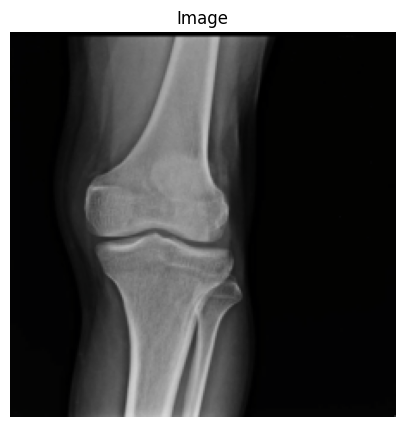

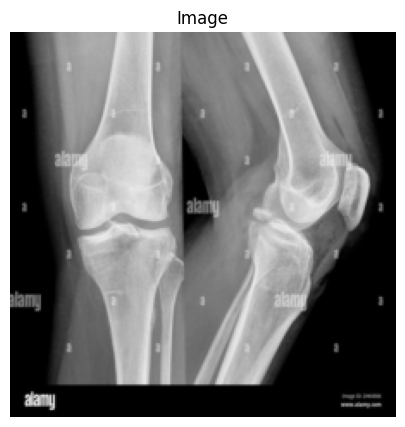

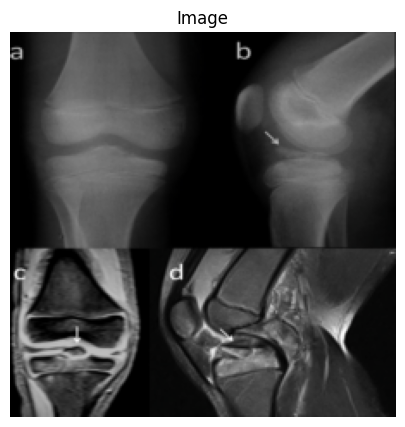

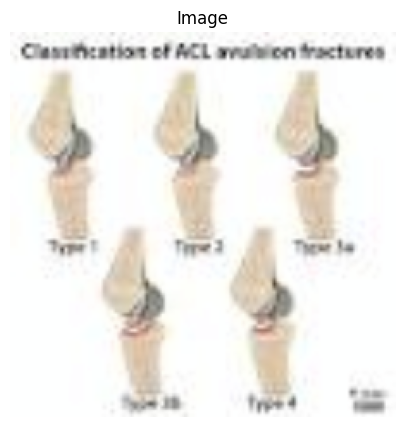

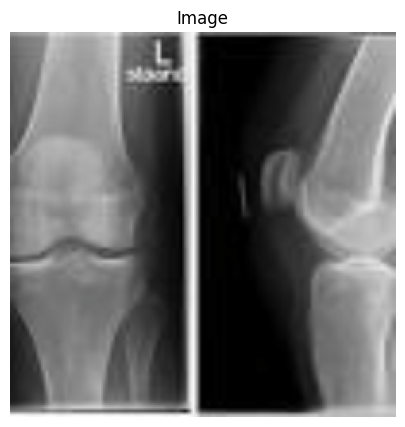

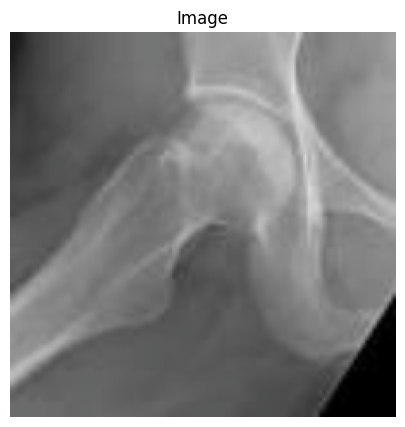

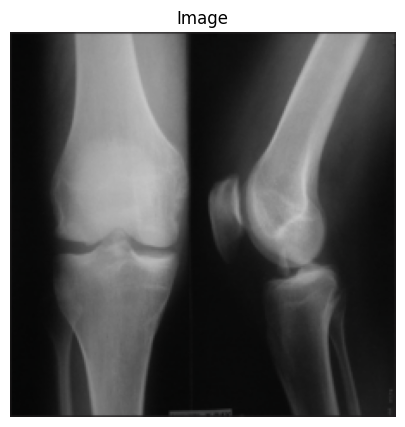

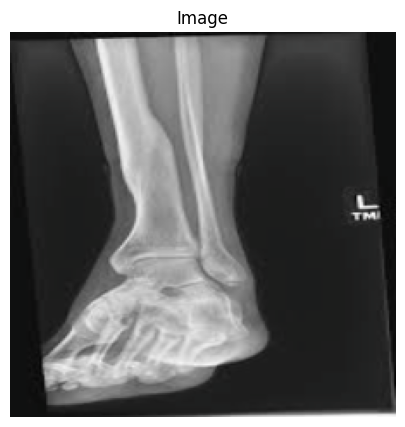

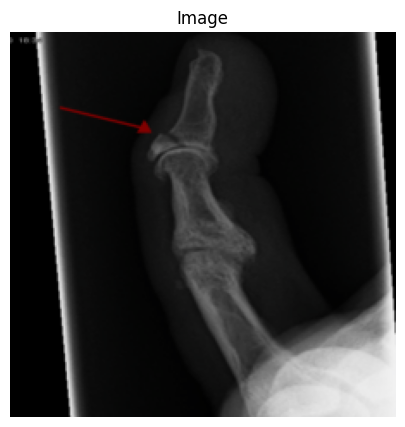

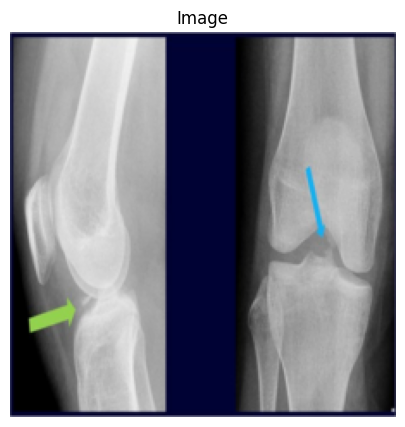

In [18]:
import numpy as np
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet std
    img = img.numpy().transpose(1, 2, 0)  # Convert to HWC
    img = img * std + mean  # Reverse normalization
    img = np.clip(img, 0, 1)  # Clip values to [0,1]
    return img
for i in range(10):
    img, mask = train_dataset[i]
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))
    axes.imshow(denormalize(img))
    axes.set_title("Image")
    axes.axis("off")
    plt.show()

# TASK 3: Define the Model

### You should finetune EfficientNetV2 Medium. Can be imported as follows:

from torchvision.models import efficientnet_v2_m

In [19]:
from torchvision.models import efficientnet_v2_m
import torch.nn as nn
model = efficientnet_v2_m(pretrained=True)

# Modify the classifier for Bone fracture classification (12 classes)
model = model.requires_grad_(False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 12).requires_grad_(True)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

# TASK 4: Training and Validation Loops

In [20]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)


        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Track accuracy
        outputs = torch.softmax(outputs, dim=1)
        predictions = outputs.argmax(dim=1)  # Get class with highest probability
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_loss += loss.item()

            # Compute accuracy
            outputs = torch.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1)  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy


# TASK 5: Running Training

## (Bonus Task: Reach 50% Accuracy in the validation set. You may want to tune the learning rate and number of epochs)

In [21]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Cross entropy Classification loss (Use when there is no softmax/sigmoid in the last layer)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)  # AdamW optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")

  0%|          | 0/130 [00:00<?, ?it/s]<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
 10%|█         | 13/130 [00:12<02:07,  1.09s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 80%|████████  | 104/130 [01:17<00:15,  1.65it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes 

Epoch 1/10: Train Loss=2.4325, Train Accuracy=12.01%, Val Loss=2.3839, Val Accuracy=12.71%


  0%|          | 0/130 [00:00<?, ?it/s]<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
  8%|▊         | 11/130 [00:10<01:46,  1.12it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 11%|█         | 14/130 [00:11<01:04,  1.80it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes s

Epoch 2/10: Train Loss=2.3956, Train Accuracy=12.35%, Val Loss=2.3784, Val Accuracy=13.04%


  0%|          | 0/130 [00:00<?, ?it/s]<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
 32%|███▏      | 41/130 [00:31<00:55,  1.62it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 130/130 [01:34<00:00,  1.38it/s]
<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clon

Epoch 3/10: Train Loss=2.3782, Train Accuracy=13.34%, Val Loss=2.3645, Val Accuracy=13.46%


  0%|          | 0/130 [00:00<?, ?it/s]<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
  1%|          | 1/130 [00:01<02:44,  1.27s/it]<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
  4%|▍         | 5/130 [00:04<01:33,  1.33it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 17%|█▋        | 22/130 [00:17<01:03,  1.70it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette

Epoch 4/10: Train Loss=2.3776, Train Accuracy=12.57%, Val Loss=2.3625, Val Accuracy=13.15%


  0%|          | 0/130 [00:00<?, ?it/s]<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
 14%|█▍        | 18/130 [00:13<00:59,  1.89it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 38%|███▊      | 49/130 [00:35<00:58,  1.38it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes s

Epoch 5/10: Train Loss=2.3778, Train Accuracy=12.99%, Val Loss=2.3610, Val Accuracy=13.40%


  0%|          | 0/130 [00:00<?, ?it/s]<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
  7%|▋         | 9/130 [00:07<01:26,  1.40it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 27%|██▋       | 35/130 [00:26<00:53,  1.78it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes sh

Epoch 6/10: Train Loss=2.3684, Train Accuracy=13.08%, Val Loss=2.3583, Val Accuracy=13.54%


  0%|          | 0/130 [00:00<?, ?it/s]<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
  1%|          | 1/130 [00:01<03:08,  1.46s/it]<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
 21%|██        | 27/130 [00:20<01:08,  1.50it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 130/130 [01:32<00:00,  1.40it/s]
<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a ten

Epoch 7/10: Train Loss=2.3695, Train Accuracy=13.89%, Val Loss=2.3551, Val Accuracy=13.65%


  0%|          | 0/130 [00:00<?, ?it/s]<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
  1%|          | 1/130 [00:01<02:58,  1.38s/it]<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
  7%|▋         | 9/130 [00:06<01:09,  1.73it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 130/130 [01:33<00:00,  1.40it/s]
<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tens

Epoch 8/10: Train Loss=2.3608, Train Accuracy=13.36%, Val Loss=2.3531, Val Accuracy=13.76%


  0%|          | 0/130 [00:00<?, ?it/s]<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
  1%|          | 1/130 [00:01<03:47,  1.76s/it]<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
 21%|██        | 27/130 [00:19<01:05,  1.56it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 35%|███▌      | 46/130 [00:32<00:50,  1.67it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palett

Epoch 9/10: Train Loss=2.3588, Train Accuracy=13.69%, Val Loss=2.3479, Val Accuracy=13.88%


  0%|          | 0/130 [00:00<?, ?it/s]<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
  1%|          | 1/130 [00:01<03:50,  1.79s/it]<ipython-input-17-6f776c02cf2f>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d[0]) for d in data] #(3)
 12%|█▏        | 15/130 [00:12<01:54,  1.00it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 52%|█████▏    | 67/130 [00:49<00:50,  1.25it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palett

Epoch 10/10: Train Loss=2.3623, Train Accuracy=12.68%, Val Loss=2.3480, Val Accuracy=13.82%


# TASK 6: Plot Loss & Accuracy

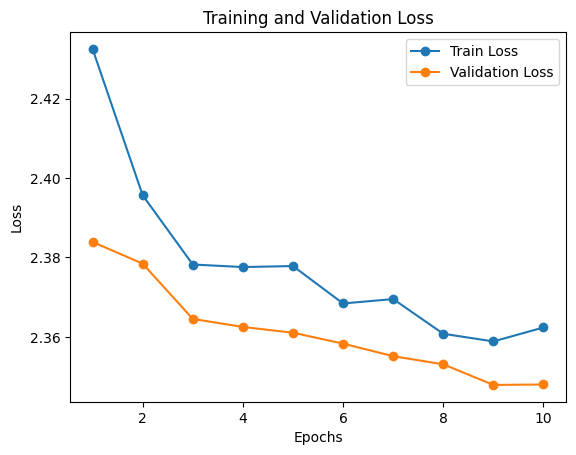

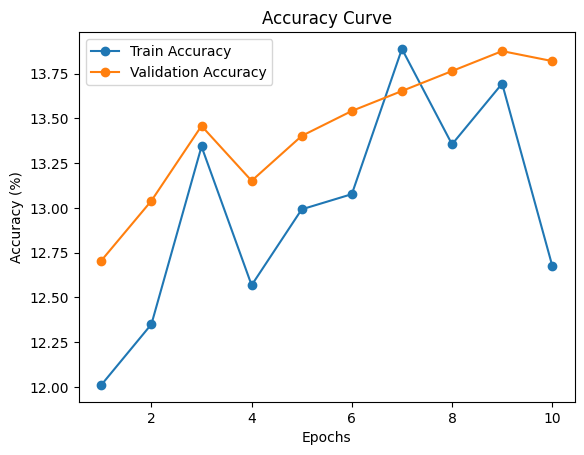

In [24]:

plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


# Plot accuracy curve

plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

# BONUS Task: K-Fold Cross-Validation

Implement 5-fold cross-validation on the training dataset and print the accuracy scores for each fold by applying these steps:
- Use the `glob` module to collect image file paths from your training dataset.
- Create a pandas DataFrame that contains the file paths and corresponding labels.
- Implement `KFold` loop to split the DataFrame into training and validation folds.
- Inside the KFold loop, initialize your train and validation dataloaders, model and run the training.



In [ ]:
from sklearn.model_selection import KFold

# TO DO